In [1]:
import os
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim

from hmmlearn import hmm

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
thmm_to_results = pd.read_csv('../results-tot-ehmm.csv')
thmm_to_results.head()

,TOT,Latent Space,Jump,Components Slow,Mixtures Slow,Components Fast,Mixtures Fast,Covariance,Mean Accuracy,Standard Deviation,Max Accuracy,Min Accuracy,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score
0,3,True,1s,1,1,1,1,full,0.450247,0.045977,0.567901,0.345679,24.0,9.0,22.0,26.0,0.727273,0.480000,0.578313
1,3,True,1s,1,1,1,1,diag,0.456173,0.038227,0.543210,0.345679,30.0,3.0,14.0,34.0,0.909091,0.468750,0.618557
2,3,True,1s,1,1,1,1,spherical,0.550864,0.048567,0.641975,0.395062,17.0,16.0,35.0,13.0,0.515152,0.566667,0.539683
3,3,True,1s,1,1,1,2,full,0.438889,0.026729,0.506173,0.370370,33.0,0.0,8.0,40.0,1.000000,0.452055,0.622642
4,3,True,1s,1,1,1,2,diag,0.439506,0.045159,0.592593,0.308642,24.0,9.0,24.0,24.0,0.727273,0.500000,0.592593


In [4]:
top_10 = thmm_to_results.sort_values("Max Accuracy", ascending=False).head(10)
top_10.reset_index(drop=True, inplace=True)
top_10["Jump"] = pd.to_timedelta(top_10["Jump"]).dt.total_seconds()
top_10.rename(columns={"Covariance": "Covariance Type"}, inplace=True)
top_10["Covariance Type"] = top_10["Covariance Type"].replace({"diag": "Diagonal", "full": "Full", "spherical": "Spherical"})
top_10

,TOT,Latent Space,Jump,Components Slow,Mixtures Slow,Components Fast,Mixtures Fast,Covariance Type,Mean Accuracy,Standard Deviation,Max Accuracy,Min Accuracy,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score
0,3,True,0.5,2,3,2,2,Diagonal,0.557778,0.057467,0.753086,0.382716,17.0,16.0,44.0,4.0,0.515152,0.809524,0.629630
1,3,True,0.5,3,2,2,2,Full,0.543704,0.047716,0.728395,0.419753,16.0,17.0,43.0,5.0,0.484848,0.761905,0.592593
2,3,True,0.1,2,4,2,3,Spherical,0.585926,0.044698,0.728395,0.444444,15.0,18.0,44.0,4.0,0.454545,0.789474,0.576923
3,3,True,0.5,1,4,1,4,Spherical,0.521975,0.057060,0.716049,0.407407,18.0,15.0,40.0,8.0,0.545455,0.692308,0.610169
4,3,True,0.5,3,3,3,3,Spherical,0.542716,0.056004,0.716049,0.419753,25.0,8.0,33.0,15.0,0.757576,0.625000,0.684932
5,3,True,0.5,4,4,4,3,Spherical,0.521358,0.046876,0.716049,0.432099,16.0,17.0,42.0,6.0,0.484848,0.727273,0.581818
6,3,True,0.1,4,2,3,2,Spherical,0.590741,0.042851,0.716049,0.493827,18.0,15.0,40.0,8.0,0.545455,0.692308,0.610169
7,3,True,0.5,3,2,2,2,Diagonal,0.554198,0.049779,0.716049,0.395062,10.0,23.0,48.0,0.0,0.303030,1.000000,0.465116
8,3,True,1.0,3,3,3,3,Spherical,0.540494,0.051397,0.716049,0.407407,21.0,12.0,37.0,11.0,0.636364,0.656250,0.646154
9,3,True,1.0,3,4,4,3,Spherical,0.550617,0.049073,0.716049,0.432099,22.0,11.0,36.0,12.0,0.666667,0.647059,0.656716


In [5]:
top_10.to_csv("ehmm-tot-top-10.csv", index=False)

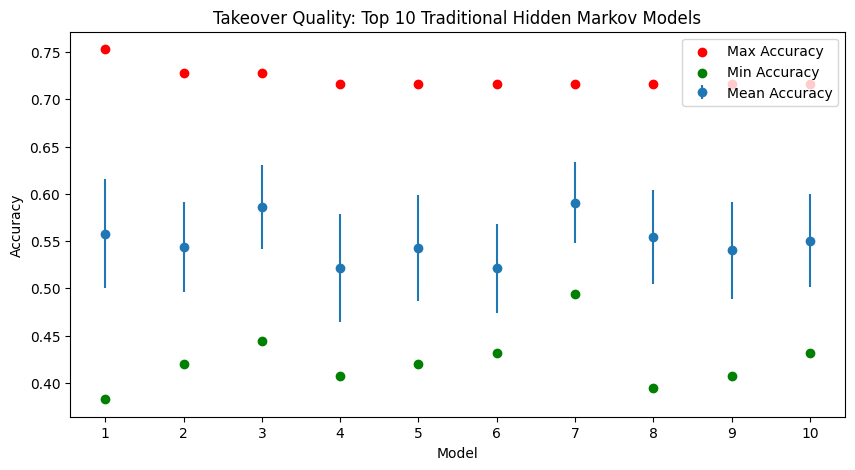

In [6]:
# Plot mean accuracy, std deviation, and max accuracy for the top 10 models
std = top_10["Standard Deviation"]
mean = top_10["Mean Accuracy"]
max_acc = top_10["Max Accuracy"]
min_acc = top_10["Min Accuracy"]
model = top_10.index + 1

plt.figure(figsize=(10, 5))
plt.errorbar(model, mean, yerr=std, fmt='o', label="Mean Accuracy")
plt.scatter(model, max_acc, color='red', label="Max Accuracy")
plt.scatter(model, min_acc, color='green', label="Min Accuracy")
plt.xticks(model)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Takeover Quality: Top 10 Traditional Hidden Markov Models")
plt.legend()
plt.show()

hyperparameter optimization ^

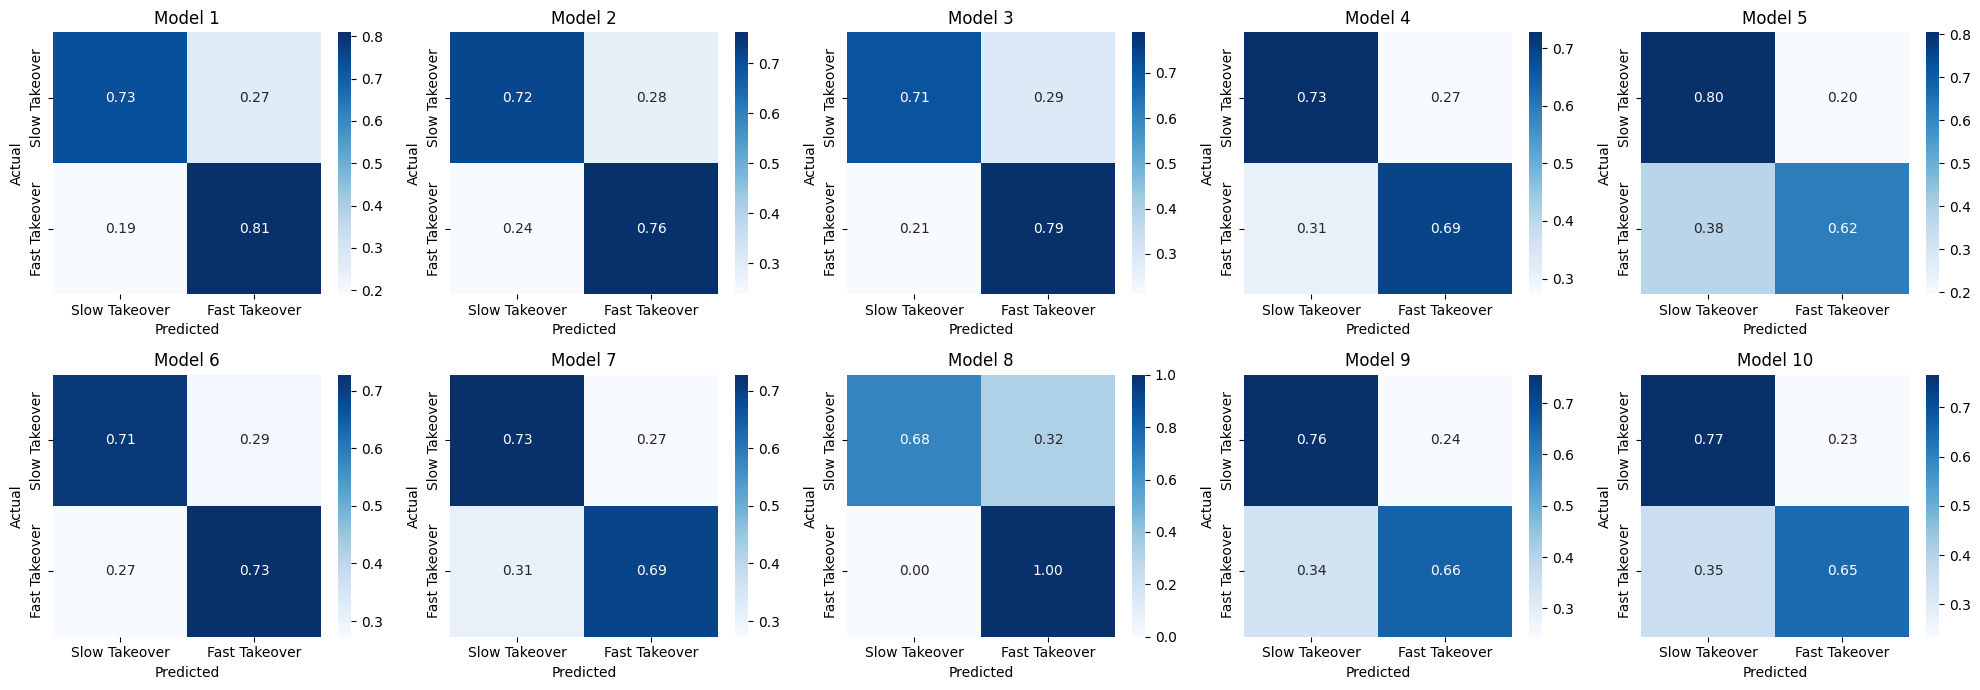

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(20, 7))

for i, ax in enumerate(axes.flatten()):
    model = top_10.iloc[i]
    tp = model["True Positives"]
    tn = model["True Negatives"]
    fp = model["False Positives"]
    fn = model["False Negatives"]
    confusion = np.array([[tn, fp], [fn, tp]])
    sns.heatmap(confusion / confusion.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Blues', ax=ax)
    ax.set_title(f"Model {i + 1}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticklabels(["Slow Takeover", "Fast Takeover"])
    ax.set_yticklabels(["Slow Takeover", "Fast Takeover"])

plt.tight_layout()
plt.show()


In [8]:
top_10[
    [
        "Jump",
        "Components Slow",
        "Mixtures Slow",
        "Components Fast",
        "Mixtures Fast",
        "Covariance Type",
        "Mean Accuracy",
        "Max Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
]

,Jump,Components Slow,Mixtures Slow,Components Fast,Mixtures Fast,Covariance Type,Mean Accuracy,Max Accuracy,Precision,Recall,F1 Score
0,0.5,2,3,2,2,Diagonal,0.557778,0.753086,0.515152,0.809524,0.629630
1,0.5,3,2,2,2,Full,0.543704,0.728395,0.484848,0.761905,0.592593
2,0.1,2,4,2,3,Spherical,0.585926,0.728395,0.454545,0.789474,0.576923
3,0.5,1,4,1,4,Spherical,0.521975,0.716049,0.545455,0.692308,0.610169
4,0.5,3,3,3,3,Spherical,0.542716,0.716049,0.757576,0.625000,0.684932
5,0.5,4,4,4,3,Spherical,0.521358,0.716049,0.484848,0.727273,0.581818
6,0.1,4,2,3,2,Spherical,0.590741,0.716049,0.545455,0.692308,0.610169
7,0.5,3,2,2,2,Diagonal,0.554198,0.716049,0.303030,1.000000,0.465116
8,1.0,3,3,3,3,Spherical,0.540494,0.716049,0.636364,0.656250,0.646154
9,1.0,3,4,4,3,Spherical,0.550617,0.716049,0.666667,0.647059,0.656716
